<a href="https://colab.research.google.com/github/benji555-create/Data-Science/blob/main/Benj_GaskU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You need to submit a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U5proj.

Ex.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU5proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU5proj.ipynb"

# Unit 5 Project: Making a Generalized Linear Model (1 predictor)

**Task**:

Two parts:

1. Propose a data set that's compatible with a generalized linear model structure built with pymc. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a generalized linear model using pymc within the colab environment, on a data set of your choice.



Guidlines:

- You are allowed to copy and paste any code from the notes, including my answer key (AK), without any reference or citations. Same goes for the course textbook, BAP3.

- This is an individual project. It is fine if you model the same process as a peer, but your raw data **must** be substantially different. "Substantially different" means that I, your instructor, arbitrarily think your data sets are different enough.

- Do not look at other student's code/jupyter notebooks. Copying, or copying and pasting, other students code will result in a failing grade. Also, I will tell all the other teachers I know that you cheated.

- If you want to know what another student did, ask them--any verbal communication about a project is allowed and encouraged. If you want to see a graphic they made, ask them to sketch a picture of it for you by hand.

- Any handwritten communication is also allowed and encouraged, so long as all parties are in the same physical location together. Example: you may sketch out a piece of code while verbally explaining to someone what you did. Do NOT: hand write the code for your entire project, take a picture, and send it to everyone in the course.

- If you use someone's code from outside this course (like from the internet, an AI, or your parent), you must ask me if it is ok, and you must cite them in your work. I don't care all they did was to click your space bar one more time: you tell me, and you cite their contribution. You don't need to tell me about or cite verbal or handwritten communication though.

- You may use a more complicated model--like something from further along in the course--IF I give you permission.

- If you are unsure whether or not something is ok or allowed: ASK BEFORE YOU DO IT.

Faliure to adhere to these guidlines will result in a failing grade.

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- Linear models are generalized linear models. This is not a competition to come up with the most complicated heirearchical glm. **Find a data set that interests you, and apply the simplest model that captures the patterns in the data.**

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- Want an example? The Unit5NotesAK *is* your example! You are expected to be somewhere between a half and three-quarters as detailed--but more is always welcome.

- Its ok to pick a data set for which you don't qute understand the context--so long as you think the context is cool.


In [54]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

I decided to test if height is a predictor of weight. It feels obvious that the taller you get, the more you weigh, but their our many different shapes and sizes of humans(looking at you, Wemby). Some could be fat and short, others skinny and tall, so I wnated to see how accurate an increase in height affected an increase in weight

Step 1. Add the data.

In [55]:
url_bigBoy = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/howell.csv'
tallSmall = pd.read_csv(url_bigBoy)

In [56]:
tallSmall

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


Step 2. Scatter Plot

<Axes: xlabel='height', ylabel='weight'>

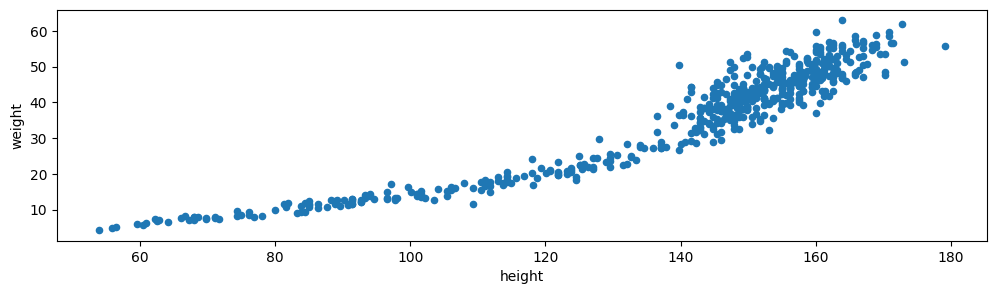

In [57]:
tallSmall.plot(x="height", y="weight", figsize=(12, 3), kind="scatter")

Very strong upward trend. Makes sense though, not a whole lot of 60 cm 40 kg people in the world. Now I'll just make a historgram, just ot find the mean and see if their are any outliers, like the 60 cm 40 kg people previously mentioned

<Axes: ylabel='Frequency'>

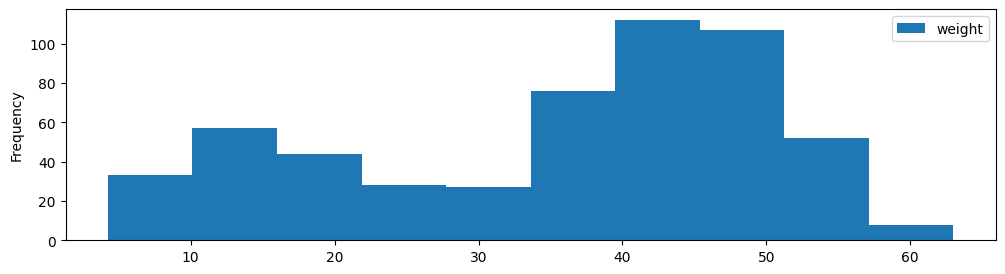

In [58]:
tallSmall.plot(x="height", y="weight", figsize=(12, 3), kind="hist")

In [61]:
with pm.Model() as model_tS:

    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    μ = pm.Deterministic("μ", α + β * tallSmall.height)

    σ = pm.HalfCauchy("σ", 10)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=tallSmall.weight)

    idata_tS = pm.sample()

Output()

Output()

In [62]:
pm.sample_posterior_predictive(idata_tS, model=model_tS,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'height')

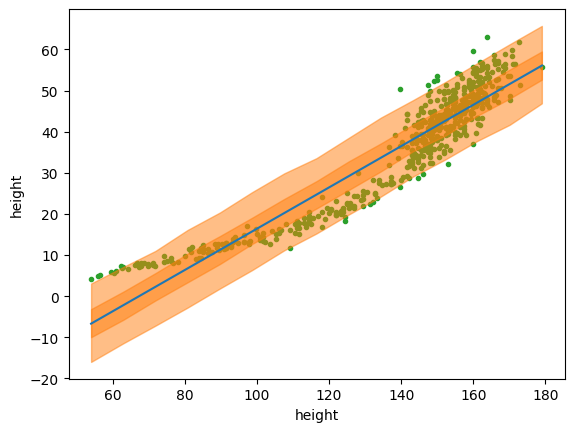

In [63]:
mean_line = idata_tS.posterior["μ"].mean(("chain", "draw"))

ages = np.random.normal(tallSmall.height.values, 0.01)
idx = np.argsort(ages)
x = np.linspace(ages.min(), ages.max(), 15)

y_pred_q = idata_tS.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(ages[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(tallSmall.height, tallSmall.weight, "C2.", zorder=-3)
ax.plot(tallSmall.height[idx], mean_line[idx], c="C0")


for ls, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, ls, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("height")

<Axes: xlabel='y_pred'>

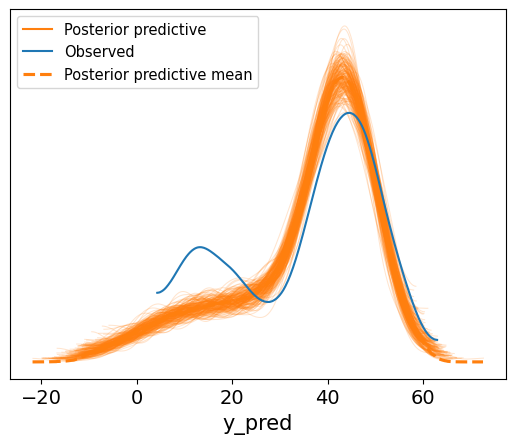

In [ ]:
az.plot_ppc(idata_tS, num_pp_samples=200, colors=["C1", "C0", "C1"])

This actually works pretty well. There is a small tail at the left side that the posterior predictive messes up, but I feel as that is just because of outliers in the data, probably kids. Another funny thing is it thinks people will weigh -20 pounds, which I think is hilarious.

I was thinking about my data set, and I thought that I should've to cut out kids. I think kids have a different height to weight ratio evidenced by my own life, as I plumped before I grew, and I wound up growing 7 inches and only gaining one pound. Little fun fact for you.  :) I'm calling a kid 15 or under, because most have gone under puberty by then.